In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
!pip install apyori

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=683da9998baca365bbea67b9a9dc35f35e21383e4330fa42ea4f2052c09c0f68
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [4]:
df = pd.read_csv('/kaggle/input/groceries-dataset/Groceries_dataset.csv')
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [5]:
df.describe()

,Member_number
count,38765.000000
mean,3003.641868
std,1153.611031
min,1000.000000
25%,2002.000000
50%,3005.000000
75%,4007.000000
max,5000.000000


In [6]:
df.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-05-01,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-01-02,whole milk


In [16]:
item = df.groupby(df['itemDescription']).size().reset_index(name='Frequency').sort_values(by = 'Frequency', ascending = False).head(10)
item

,itemDescription,Frequency
164,whole milk,2502
102,other vegetables,1898
122,rolls/buns,1716
138,soda,1514
165,yogurt,1334
123,root vegetables,1071
156,tropical fruit,1032
12,bottled water,933
130,sausage,924
30,citrus fruit,812


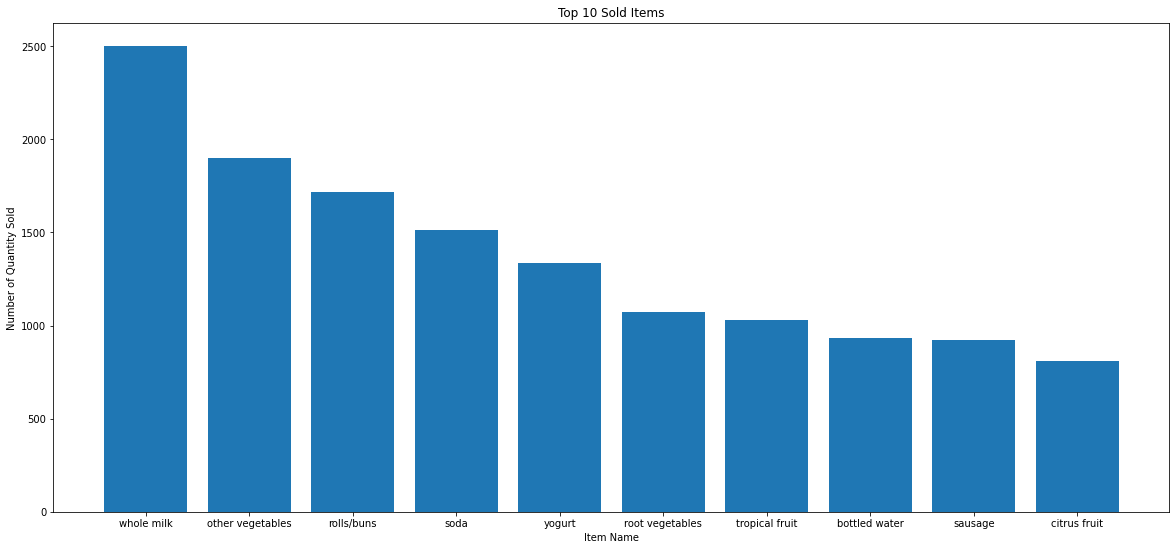

In [21]:
bars = item['itemDescription']
height = item['Frequency']
x_pos = np.arange(len(bars))
plt.figure(figsize=(20,9))
plt.bar(x_pos, height)
plt.title("Top 10 Sold Items")
plt.xlabel("Item Name")
plt.ylabel("Number of Quantity Sold")
plt.xticks(x_pos, bars)
plt.show()

In [22]:
cust_level = df[["Member_number", "itemDescription"]].sort_values(by = "Member_number", ascending = False) ## Selecting only required variables for modelling
cust_level['itemDescription'] = cust_level['itemDescription'].str.strip() # Removing white spaces if any
cust_level

,Member_number,itemDescription
3578,5000,soda
34885,5000,semi-finished bread
11728,5000,fruit/vegetable juice
9340,5000,bottled beer
19727,5000,root vegetables
...,...,...
13331,1000,whole milk
17778,1000,pickled vegetables
6388,1000,sausage
20992,1000,semi-finished bread


In [23]:
transactions = [a[1]['itemDescription'].tolist() for a in list(cust_level.groupby(['Member_number']))] ## Combing all the items in list format for each cutomer

In [24]:
from apyori import apriori ## Importing apriori package
rules = apriori(transactions = transactions, min_support = 0.002, min_confidence = 0.05, min_lift = 3, min_length = 2, max_length = 2)

In [25]:
results = list(rules) 
results

[RelationRecord(items=frozenset({'UHT-milk', 'kitchen towels'}), support=0.002308876346844536, ordered_statistics=[OrderedStatistic(items_base=frozenset({'kitchen towels'}), items_add=frozenset({'UHT-milk'}), confidence=0.30000000000000004, lift=3.821568627450981)]),
 RelationRecord(items=frozenset({'potato products', 'beef'}), support=0.002565418163160595, ordered_statistics=[OrderedStatistic(items_base=frozenset({'potato products'}), items_add=frozenset({'beef'}), confidence=0.4545454545454546, lift=3.8021849395239955)]),
 RelationRecord(items=frozenset({'coffee', 'canned fruit'}), support=0.002308876346844536, ordered_statistics=[OrderedStatistic(items_base=frozenset({'canned fruit'}), items_add=frozenset({'coffee'}), confidence=0.4285714285714286, lift=3.7289540816326534)]),
 RelationRecord(items=frozenset({'domestic eggs', 'meat spreads'}), support=0.0035915854284248334, ordered_statistics=[OrderedStatistic(items_base=frozenset({'meat spreads'}), items_add=frozenset({'domestic egg

In [26]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [27]:
resultsinDataFrame.nlargest(n=10, columns="Lift")

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
0,kitchen towels,UHT-milk,0.002309,0.300000,3.821569
1,potato products,beef,0.002565,0.454545,3.802185
2,canned fruit,coffee,0.002309,0.428571,3.728954
4,flour,mayonnaise,0.002309,0.063380,3.338599
6,sparkling wine,waffles,0.002565,0.217391,3.150154
5,rice,napkins,0.003079,0.244898,3.011395
3,meat spreads,domestic eggs,0.003592,0.400000,3.004239
